In [1]:
# all imports 
%pylab inline

import os
import sys
import socket

sys.path.append("/root")
sys.path.append("/home/peter")
sys.path.append("/home/peter/Desktop")
sys.path.append("/home/peter/Desktop/projects")
sys.path.append("/home/peter/Desktop/work")
sys.path.append("/home/peter/code/projects")
sys.path.append("/home/peter/code/work")
sys.path.append("/home/peter/code/common")

from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
from IPython.display import clear_output, display, HTML

import cv2
import os
import pickle as pkl
from sklearn import linear_model
from sklearn.decomposition import PCA
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

import theano.tensor as T
import theano as th
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn as sk
import time
#from aidevutil import *
import cymysql as sql
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import datetime
import time
from trading_env import TradingEnv
from numba import jit
from sklearn.preprocessing import scale, robust_scale, normalize

Populating the interactive namespace from numpy and matplotlib


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_9jhbd8hs.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1050 with Max-Q Design (0000:02:00.0)


In [2]:
input_source = np.load(open('data/data_btc_1h.npy','rb'))
to_predict = np.load(open('data/data_btc_1h_targets.npy','rb'))

to_predict = to_predict[3,:].reshape(-1)

In [3]:
input_source.shape

(176, 16900)

In [4]:
input_source = input_source.T

In [5]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [6]:
test_input_source = test_input_source.T
input_source = input_source.T

In [7]:
input_source.shape, test_input_source.shape

((176, 13520), (176, 3380))

In [8]:
to_predict[0:50]

array([2541.67, 2561.88, 2561.11, 2565.42, 2564.37, 2564.66, 2566.99,
       2572.95, 2559.39, 2555.95, 2549.65, 2548.63, 2553.98, 2554.6 ,
       2553.34, 2552.78, 2552.33, 2556.92, 2559.32, 2555.67, 2553.79,
       2539.82, 2542.72, 2538.99, 2535.  , 2522.98, 2508.99, 2497.15,
       2517.  , 2514.86, 2511.02, 2512.94, 2516.73, 2516.29, 2515.91,
       2515.  , 2517.83, 2514.75, 2494.88, 2470.  , 2430.73, 2403.21,
       2383.14, 2412.81, 2420.19, 2399.22, 2404.61, 2390.  , 2341.31,
       2332.92])

In [9]:
winlen = 1

In [10]:
sliding_window_jump = 1
predict_time_ahead = 1

In [11]:
@jit
def get_partitioned_counts(cl, rr, rt):
    " data, steps_forward, partition_num"
    cl = cl[rr:] - cl[0:-rr]
    cl = np.hstack([[0]*rr, cl])
    pdown = len(cl[cl < -rt])
    pup = len(cl[cl > rt])
    pmid = len(cl[(cl <= rt) & (cl >= -rt)])
    return pup, pmid, pdown

In [12]:
@jit
def partition_data_num(cl, predict_ahead):
    a=[]
    b=[]
    c=[]
    ts = np.linspace(0.001, 100.0, 100000, )
    for x in tqdm(ts):
        au, am, ad = get_partitioned_counts(cl, predict_ahead, x)
        a.append(au)
        b.append(am)
        c.append(ad)
    a, b, c = array(a), array(b), array(c)
    return ts[np.argmin(np.abs(a-b) + np.abs(a-c) + np.abs(b-c))]

In [13]:
binary=1

In [14]:
# create training set
if not binary:
    sep = partition_data_num(to_predict, predict_time_ahead)
    sep

In [15]:
#@jit
def prepare_data(input_source, to_predict, binary=1):

    x = []
    y = []

    ups = []
    downs = []
    mids = []

    for i in range(0, input_source.shape[1]-(winlen+100), sliding_window_jump):
        # form the input
        txs = input_source[:, i:i+winlen]#.astype(np.float64)
        #xs = scale(xs, axis=1)
        xs = txs.ravel()

        # for the output
        now = to_predict[i+winlen-1]# close
        future = to_predict[i+winlen+(predict_time_ahead-1)] # next close

        ys = future-now
        magn = abs(ys)

        if not binary:
            if magn < sep:
                mids.append( (xs, (np.array([1]))) )
            else:
                if ys < 0:
                    downs.append( (xs, (np.array([2]))) )
                else:
                    ups.append( (xs, (np.array([0]))) )
        else:
            if ys <= 0:
                downs.append( (xs, (np.array([1]))) )
            else:
                ups.append( (xs, (np.array([0]))) )

        #if (i%1000)==0:
        #    clear_output(wait=True)
        #    print('({}/{})'.format(i, input_source.shape[1]-winlen))

    #print('Ups: {0} Mids: {1} Downs: {2}'.format(len(ups), len(mids), len(downs)))
    #print('Separator: %3.5f' % sep)
    #print()

    if not binary:
        samplesize = min(len(ups), len(downs), len(mids))
        s1 = rnd.sample(ups, samplesize)
        s2 = rnd.sample(downs, samplesize)
        s3 = rnd.sample(mids, samplesize)
        a = s1 + s2 + s3
    else:
        samplesize = min(len(ups), len(downs))
        s1 = rnd.sample(ups, samplesize)
        s2 = rnd.sample(downs, samplesize)
        a = s1 + s2 
    rnd.shuffle(a)
    x = [x[0] for x in a]
    y = [x[1] for x in a]

    x = np.vstack(x)
    y = np.vstack(y)
    
    x.shape = (x.shape[0], -1)
    cutpoint = int(0.8 * x.shape[0])
    x_train = x[0:cutpoint]
    x_test = x[cutpoint:]
    y_train = y[0:cutpoint]
    y_test = y[cutpoint:]
    
    return x_train, x_test, y_train.reshape(-1), y_test.reshape(-1)

In [16]:
%%time 
x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)

CPU times: user 121 ms, sys: 15.7 ms, total: 136 ms
Wall time: 133 ms


In [17]:
input_source.shape

(176, 13520)

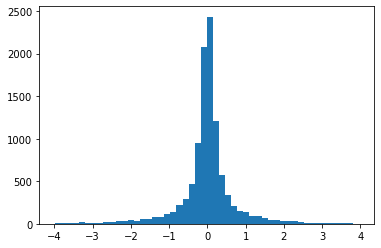

In [18]:
# get the range, remove all outliers too
d = scale(x_train[:,0].reshape(-1))
d = d[where((d > -4) & (d < 4))]
hist(d, 50);
bins = np.linspace(min(d), max(d), 10)
dc = np.digitize(d, bins)

In [19]:
min(d), max(d)

(-3.992604902746865, 3.9675269361655934)

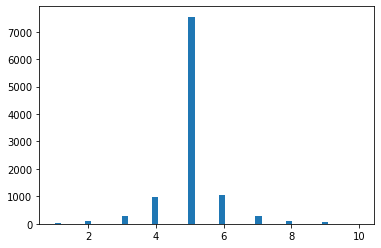

In [21]:
hist(dc, 50);


In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
# Classifiers

In [20]:
num_clfs = 1
clfs = [LogisticRegression() for x in range(num_clfs)] 

In [21]:
%%time
for clf in tqdm(clfs):
    x_train, x_test, y_train, y_test = prepare_data(input_source, to_predict)
    clf.fit(x_train, y_train)

In [22]:
scores_tr = [clf.score(x_train, y_train) for clf in clfs]

In [23]:
hist(scores_tr, 20);

In [24]:
scores_ts = [clf.score(x_test,y_test) for clf in clfs]

In [25]:
hist(scores_ts, 20);

In [26]:
# Here the model is saved
#pkl.dump(clf, open('test.pkl','wb'))

In [27]:
input_source.shape, to_predict.shape, test_input_source.shape, test_to_predict.shape

In [28]:
binary=1

In [29]:
traded_amt = 100
commission = 0
slippage = 0
initial_balance = 100000000

In [30]:
def plot_backtest(datapair, clf):
    input_source, to_predict = datapair
    bars_per_episode = len(to_predict) - 1000
    env = TradingEnv(input_source.T, to_predict,
                     winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                     commission=commission, slippage=slippage,
                     initial_balance=initial_balance,
                     reward_type='cur_balance',
                     min_ratio_trades = 20,
                     max_position_time = 0,
                     )
    observation = env.reset()
    done = False
    navs = []
    acts = []
    for i in tqdm(range(env.bars_per_episode)):
        aa = [clf.predict([observation]) for clf in clfs]
        aa = [int(a) for a in aa]
        # get the average
        a = round(mean(aa))
        if not binary:
            if   a == 0: # up
                action = 0 # buy
            elif a == 1: # mid 
                action = 3 # do nothing
            elif a == 2: # down
                action = 1 # sell
        else:
            if   a == 0: # up
                action = 0 # buy
            elif a == 1: # down
                action = 1 # sell
        acts.append(action)
        observation, reward, done, info = env.step(action)
        if done:
            break
    navs = env.returns
    kl = []
    t = 0
    for n in navs:
        t = t + n
        kl.append(t)
    plt.plot(kl)
    plt.show()

In [31]:
plot_backtest((input_source, to_predict), clf)

In [32]:
plot_backtest((test_input_source, test_to_predict), clf)